### Testing Raw Cible WB

## Part 1: Setup and Data Loading


In [1]:
### Dowload and install dependencies for the project
# %matplotlib inline
%pip install setuptools wheel cython statsmodels
%pip install kaleido jinja2


[notice] A new release of pip available: 22.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
### ====================
### Importing libraries
### ====================
%load_ext autoreload
%autoreload 2
import sys
import openpyxl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

#import shap
import os
import warnings

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
### ====================
### Set up visualization and warnings
### ====================
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
# sns.set_palette('viridis')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2025-06-06 16:49:04.692565: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-06 16:49:04.882638: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-06-06 16:49:04.882667: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-06-06 16:49:04.920203: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-06 16:49:06.155762: W tensorflow/stream_executor/platform/de

In [3]:
### ====================
### File paths
###  ===================
# Create directories for model saving
models_dir = '../../models'
for model_type in ['simple_models', 'ml_models', 'dl_models']:
    models_dir = os.path.join(models_dir, model_type)
    os.makedirs(models_dir, exist_ok=True)

# Load Excel file
maquettes_path = "../../data/raw/"

maquettes= ["RawData-Cibles.xlsx"]
for maquette in maquettes:
    maquettes_path = os.path.join(maquettes_path, maquette)
sheets = ["Mur", "Sols", "Poutre", "Poteaux"]  # Adjusted based on your description

processed_data_path = os.path.join("../../data/processed/", os.path.splitext(maquette)[0])
os.makedirs(processed_data_path, exist_ok=True)


## Import Pythoon Modules
sys.path.append("../../module_python")

### Export Plots
# Create a folder for plots specific to the current maquette
plots_folder = os.path.join("../../plot", os.path.splitext(maquette)[0])
os.makedirs(plots_folder, exist_ok=True)


In [4]:
import excel_data_loader
data = excel_data_loader.load_data(maquettes_path)


# Access the DataFrames
murs_df = data.get('Murs')
sols_df = data.get('Sols')
poutres_df = data.get('Poutres')
poteaux_df = data.get('Poteaux')

# Display basic info
print("Murs DataFrame Shape:", murs_df.shape)
print("Sols DataFrame Shape:", sols_df.shape)
print("Poutres DataFrame Shape:", poutres_df.shape)
print("Poteaux DataFrame Shape:", poteaux_df.shape)

# Display column names
for sheet_name, df in data.items():
    print(f"\n{sheet_name} DataFrame Preview:")
    print(df.columns)

Data loaded successfully from the Excel file.
Murs DataFrame Shape: (312, 96)
Sols DataFrame Shape: (107, 94)
Poutres DataFrame Shape: (246, 100)
Poteaux DataFrame Shape: (68, 87)

Murs DataFrame Preview:
Index(['Id', '011EC_Lot', '012EC_Ouvrage', '013EC_Localisation',
       '014EC_Mode Constructif', 'Nom', 'Hauteur', 'Epaisseur', 'AI', 'AS',
       'Sols en intersection', 'Sols coupés (u)', 'Sols coupés (Ids)',
       'Sols coupants (u)', 'Sols coupants (Ids)', 'Sol au-dessus',
       'Sol en-dessous', 'Fenêtres', 'Portes', 'Ouvertures', 'Murs imbriqués',
       'Mur multicouche', 'Mur empilé', 'Profil modifié', 'Image', 'Catégorie',
       'Section', 'Type prédéfini d'IFC', 'Exporter au format IFC sous',
       'Exporter au format IFC', 'IfcGUID', 'A une association',
       'Enrobage d'armature - Autres faces',
       'Enrobage d'armature - Face intérieure',
       'Enrobage d'armature - Face extérieure', 'Variantes',
       'Extension inférieure', 'Extension supérieure', 'Volume',

## Part 2: Data Preprocessing and Relationship Mapping


📂 Loading and sanitizing Excel file...
✅ Murs: Sanitized 31 columns
✅ Sols: Sanitized 23 columns
✅ Poutres: Sanitized 23 columns
✅ Poteaux: Sanitized 26 columns
🔍 COLUMN MAPPING ANALYSIS

📊 DataFrame Column Counts:
   Murs: 31 columns
   Sols: 23 columns
   Poutres: 23 columns
   Poteaux: 26 columns

🌐 Total Unique Columns Across All DataFrames: 103

🤝 Common Columns (found in multiple DataFrames): 0

🔗 Relationship Columns (coupés/coupants mappings): 15
   'Sol_Murs_coupants_Ids' in Sols → references 'Mur_Id' in Murs
   'Sol_Poutres_coupés_Ids' in Sols → references 'Poutre_Id' in Poutres
   'Sol_Murs_coupés_Ids' in Sols → references 'Mur_Id' in Murs
   'Sol_Poutres_coupants_Ids' in Sols → references 'Poutre_Id' in Poutres
   'Poteau_Sols_coupés_Ids' in Poteaux → references 'Sol_Id' in Sols
   'Poutre_Sols_coupés_Ids' in Poutres → references 'Sol_Id' in Sols
   'Poteau_Poutres_coupants_Ids' in Poteaux → references 'Poutre_Id' in Poutres
   'Poutre_Sols_coupants_Ids' in Poutres → refere

,Murs,Sols,Poutres,Poteaux


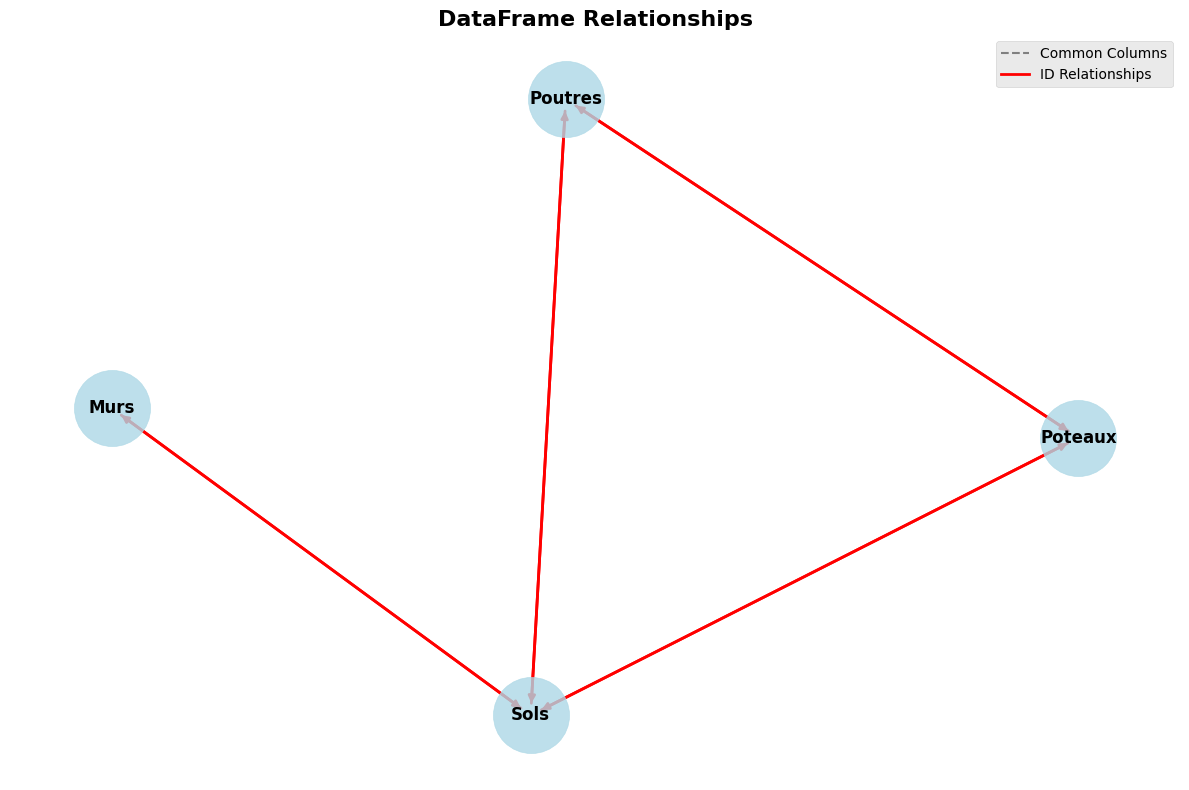

In [5]:
### ========================================
### Sanitization and Relationship Analysis
### ========================================
### Import the cleaner and mapper
from excel_essential_columns_cleaner import load_and_sanitize_data
from excel_map_sanitized_columns import analyze_relationships, display_column_mapping_results, generate_relationship_graph_matplotlib

# Load and fully sanitize the data
sanitized_data = load_and_sanitize_data(maquettes_path)

### Now ALL subsequent operations use the sanitized data
### --------------------------------------------------

### Analyze relationships
relationships = analyze_relationships(sanitized_data)

### Display results
display_column_mapping_results(relationships, sanitized_data)


### Now work exclusively with sanitized_data for all operations
murs_df = sanitized_data['Murs']
sols_df = sanitized_data['Sols']
poutres_df = sanitized_data['Poutres']
poteaux_df = sanitized_data['Poteaux']

### Generate graph
generate_relationship_graph_matplotlib(relationships)
### save the graph if not already saved
maquette_name = os.path.splitext(os.path.basename(maquettes_path))[0]  # Extract maquette name from file path
graph_path = os.path.join(plots_folder, f"{maquette_name}_relationship_graph.png")
if not os.path.exists(graph_path):
    plt.savefig(graph_path, bbox_inches='tight')
    print(f"Graph saved to {graph_path}")

In [6]:
import excel_clean_ids_columns

df_dict = {'Murs': murs_df, 'Sols': sols_df, 'Poutres': poutres_df, 'Poteaux': poteaux_df}

cleaned_dfs, renamed_columns = excel_clean_ids_columns.clean_ids_columns(df_dict)

🛁 Starting ID columns cleaning...

📋 Murs:

 🔄 Processing: Mur_Sols_coupés_u ↔ Mur_Sols_coupés_Ids


,Before_u,After_u,Before_ids,After_ids
0,0,0,nan,0
1,0,0,nan,0
2,0,0,nan,0


 ✨ Renamed to: Mur_Sols_coupés_Ids_cleaned
──────────────────────────────────────────────────

 🔄 Processing: Mur_Sols_coupants_u ↔ Mur_Sols_coupants_Ids


,Before_u,After_u,Before_ids,After_ids
0,3,3,"1788267,1788458,1790282","1788267,1788458,1790282"
1,1,1,1788267,1788267
2,1,1,1788267,1788267


 ✨ Renamed to: Mur_Sols_coupants_Ids_cleaned
──────────────────────────────────────────────────
📋 Sols:

 🔄 Processing: Sol_Murs_coupés_u ↔ Sol_Murs_coupés_Ids


,Before_u,After_u,Before_ids,After_ids
0,0,0,nan,0
1,9,9,"1787858,1787860,1787874,1789104,1789106,179026...","1787858,1787860,1787874,1789104,1789106,179026..."
2,3,3,"1788054,1789308,1794860","1788054,1789308,1794860"


 ✨ Renamed to: Sol_Murs_coupés_Ids_cleaned
──────────────────────────────────────────────────

 🔄 Processing: Sol_Murs_coupants_u ↔ Sol_Murs_coupants_Ids


,Before_u,After_u,Before_ids,After_ids
0,0,0,nan,0
1,0,0,nan,0
2,0,0,nan,0


 ✨ Renamed to: Sol_Murs_coupants_Ids_cleaned
──────────────────────────────────────────────────

 🔄 Processing: Sol_Poutres_coupés_u ↔ Sol_Poutres_coupés_Ids


,Before_u,After_u,Before_ids,After_ids
0,1,1,1793428,1793428
1,1,1,1788274,1788274
2,0,0,nan,0


 ✨ Renamed to: Sol_Poutres_coupés_Ids_cleaned
──────────────────────────────────────────────────

 🔄 Processing: Sol_Poutres_coupants_u ↔ Sol_Poutres_coupants_Ids


,Before_u,After_u,Before_ids,After_ids
0,0,0,nan,0
1,0,0,nan,0
2,0,0,nan,0


 ✨ Renamed to: Sol_Poutres_coupants_Ids_cleaned
──────────────────────────────────────────────────

 🔄 Processing: Sol_Poteaux_coupés_u ↔ Sol_Poteaux_coupés_Ids


,Before_u,After_u,Before_ids,After_ids
0,0,0,nan,0
1,0,0,nan,0
2,0,0,nan,0


 ✨ Renamed to: Sol_Poteaux_coupés_Ids_cleaned
──────────────────────────────────────────────────

 🔄 Processing: Sol_Poteaux_coupants_u ↔ Sol_Poteaux_coupants_Ids


,Before_u,After_u,Before_ids,After_ids
0,0,0,nan,0
1,0,0,nan,0
2,0,0,nan,0


 ✨ Renamed to: Sol_Poteaux_coupants_Ids_cleaned
──────────────────────────────────────────────────
📋 Poutres:

 🔄 Processing: Poutre_Sols_coupés_u ↔ Poutre_Sols_coupés_Ids


,Before_u,After_u,Before_ids,After_ids
0,0,0,nan,0
1,0,0,nan,0
2,0,0,nan,0


 ✨ Renamed to: Poutre_Sols_coupés_Ids_cleaned
──────────────────────────────────────────────────

 🔄 Processing: Poutre_Sols_coupants_u ↔ Poutre_Sols_coupants_Ids


,Before_u,After_u,Before_ids,After_ids
0,0,0,nan,0
1,0,0,nan,0
2,0,0,nan,0


 ✨ Renamed to: Poutre_Sols_coupants_Ids_cleaned
──────────────────────────────────────────────────

 🔄 Processing: Poutre_Poteaux_coupés_u ↔ Poutre_Poteaux_coupés_Ids


,Before_u,After_u,Before_ids,After_ids
0,0,0,nan,0
1,0,0,nan,0
2,0,0,nan,0


 ✨ Renamed to: Poutre_Poteaux_coupés_Ids_cleaned
──────────────────────────────────────────────────
 ⚠️ Poutre_Poteaux_coupants_u → No matching IDs column
📋 Poteaux:

 🔄 Processing: Poteau_Sols_coupés_u ↔ Poteau_Sols_coupés_Ids


,Before_u,After_u,Before_ids,After_ids
0,0,0,nan,0
1,0,0,nan,0
2,0,0,nan,0


 ✨ Renamed to: Poteau_Sols_coupés_Ids_cleaned
──────────────────────────────────────────────────

 🔄 Processing: Poteau_Sols_coupants_u ↔ Poteau_Sols_coupants_Ids


,Before_u,After_u,Before_ids,After_ids
0,1,1,1788810,1788810
1,0,0,nan,0
2,0,0,nan,0


 ✨ Renamed to: Poteau_Sols_coupants_Ids_cleaned
──────────────────────────────────────────────────

 🔄 Processing: Poteau_Poutres_coupés_u ↔ Poteau_Poutres_coupés_Ids


,Before_u,After_u,Before_ids,After_ids
0,2,2,"1788966,1795639","1788966,1795639"
1,1,1,1788934,1788934
2,1,1,1788936,1788936


 ✨ Renamed to: Poteau_Poutres_coupés_Ids_cleaned
──────────────────────────────────────────────────

 🔄 Processing: Poteau_Poutres_coupants_u ↔ Poteau_Poutres_coupants_Ids


,Before_u,After_u,Before_ids,After_ids
0,0,0,nan,0
1,0,0,nan,0
2,0,0,nan,0


 ✨ Renamed to: Poteau_Poutres_coupants_Ids_cleaned
──────────────────────────────────────────────────

✅ FINAL COLUMNS PER DATAFRAME:

📌 Murs columns:
 • Mur_Id 
 • Mur_011EC_Lot 
 • Mur_012EC_Ouvrage 
 • Mur_013EC_Localisation 
 • Mur_014EC_Mode_Constructif 
 • Mur_Hauteur 
 • Mur_Epaisseur 
 • Mur_AI 
 • Mur_AS 
 • Mur_Sols_en_intersection 
 • Mur_Sols_coupés_u 
 • Mur_Sols_coupés_Ids_cleaned (renamed)
 • Mur_Sols_coupants_u 
 • Mur_Sols_coupants_Ids_cleaned (renamed)
 • Mur_Sol_au-dessus 
 • Mur_Sol_en-dessous 
 • Mur_Fenêtres 
 • Mur_Portes 
 • Mur_Ouvertures 
 • Mur_Murs_imbriqués 
 • Mur_Mur_multicouche 
 • Mur_Profil_modifié 
 • Mur_Extension_inférieure 
 • Mur_Extension_supérieure 
 • Mur_Volume 
 • Mur_Surface 
 • Mur_Partie_inférieure_attachée 
 • Mur_Partie_supérieure_attachée 
 • Mur_Décalage_supérieur 
 • Mur_Décalage_inférieur 
 • Mur_Matériau_structurel 

📌 Sols columns:
 • Sol_Id 
 • Sol_011EC_Lot 
 • Sol_012EC_Ouvrage 
 • Sol_013EC_Localisation 
 • Sol_014EC_Mode_Const


🔍 Processing Murs...
✅ Found & Processed: Mur_Sols_coupés_Ids_cleaned, Added Count Column: Mur_Sols_coupés_Ids_cleaned_count
✅ Found & Processed: Mur_Sols_coupants_Ids_cleaned, Added Count Column: Mur_Sols_coupants_Ids_cleaned_count

🔍 Processing Sols...
✅ Found & Processed: Sol_Murs_coupés_Ids_cleaned, Added Count Column: Sol_Murs_coupés_Ids_cleaned_count
✅ Found & Processed: Sol_Murs_coupants_Ids_cleaned, Added Count Column: Sol_Murs_coupants_Ids_cleaned_count
✅ Found & Processed: Sol_Poutres_coupés_Ids_cleaned, Added Count Column: Sol_Poutres_coupés_Ids_cleaned_count
✅ Found & Processed: Sol_Poutres_coupants_Ids_cleaned, Added Count Column: Sol_Poutres_coupants_Ids_cleaned_count
✅ Found & Processed: Sol_Poteaux_coupés_Ids_cleaned, Added Count Column: Sol_Poteaux_coupés_Ids_cleaned_count
✅ Found & Processed: Sol_Poteaux_coupants_Ids_cleaned, Added Count Column: Sol_Poteaux_coupants_Ids_cleaned_count

🔍 Processing Poutres...
✅ Found & Processed: Poutre_Sols_coupés_Ids_cleaned, Added 

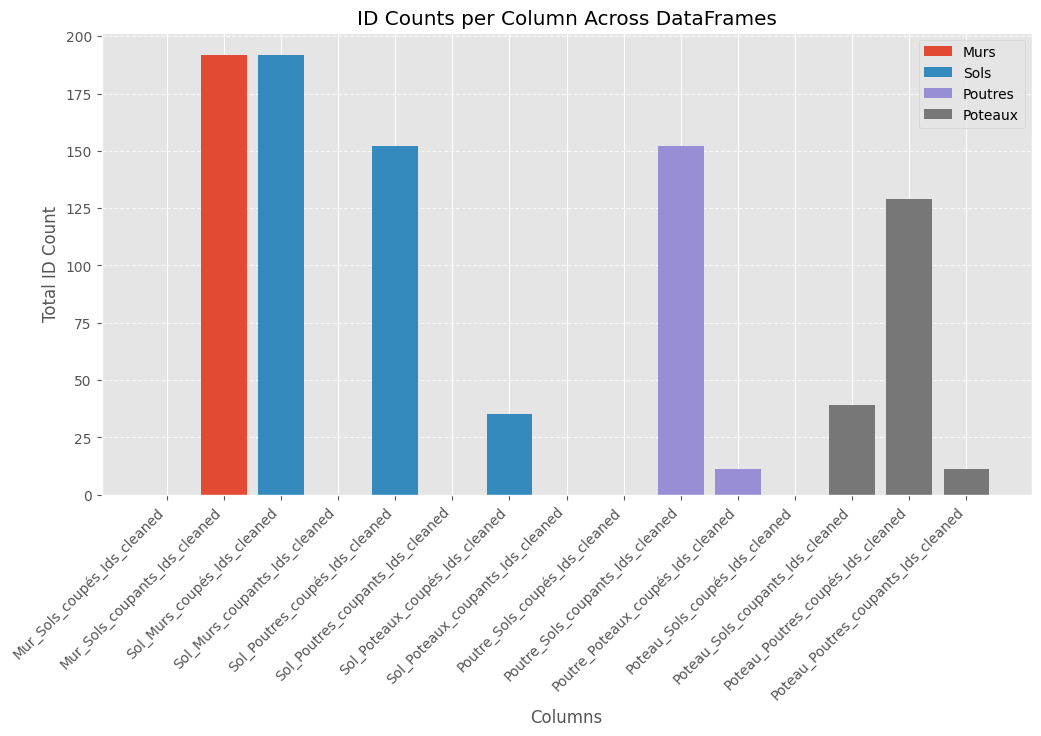

In [7]:
from excel_insertions_ids_counter import count_ids_per_row, plot_id_counts

df_dict, renamed_columns = count_ids_per_row(df_dict)
### ======================
### Show detected columns
### ======================
print("\n🆕 Processed Columns:")
for col_name in renamed_columns.keys():
    print(f"Detected & counted: {col_name}")

### ========================================
### Validate count columns in each DataFrame
### ========================================
for name, df in df_dict.items():
    df_count_cols = [col + "_count" for col in renamed_columns.keys() if (col + "_count") in df.columns]
    print(f"\n{name} DataFrame count columns:")
    if df_count_cols:
        print(df[df_count_cols].head())
    else:
        print("⚠️ No count columns found.")

### ========================================
### Generate plot based on processed data
### ========================================
plot_id_counts(df_dict, renamed_columns)
### save the graph if not already saved
graph_path = os.path.join(plots_folder, f"{maquette_name}_id_counts.png")
if not os.path.exists(graph_path):
    plt.savefig(graph_path, bbox_inches='tight')
    print(f"Graph saved to {graph_path}")


🔍 Processing relationships for Murs...
🔗 Linking Mur_Sols_coupés_Ids_cleaned in Murs → Sols
✅ Successfully linked 28 features from Sols
🔗 Linking Mur_Sols_coupants_Ids_cleaned in Murs → Sols
❌ Failed to process Mur_Sols_coupants_Ids_cleaned: cannot reindex on an axis with duplicate labels
🔗 Linking Mur_Sols_coupés_Ids_cleaned_count in Murs → Sols
✅ Successfully linked 28 features from Sols
🔗 Linking Mur_Sols_coupants_Ids_cleaned_count in Murs → Sols
✅ Successfully linked 28 features from Sols

🔍 Processing relationships for Sols...
🔗 Linking Sol_Murs_coupés_Ids_cleaned in Sols → Murs
❌ Failed to process Sol_Murs_coupés_Ids_cleaned: cannot reindex on an axis with duplicate labels
🔗 Linking Sol_Murs_coupants_Ids_cleaned in Sols → Murs
✅ Successfully linked 60 features from Murs
🔗 Linking Sol_Poutres_coupés_Ids_cleaned in Sols → Poutres
❌ Failed to process Sol_Poutres_coupés_Ids_cleaned: cannot reindex on an axis with duplicate labels
🔗 Linking Sol_Poutres_coupants_Ids_cleaned in Sols → 

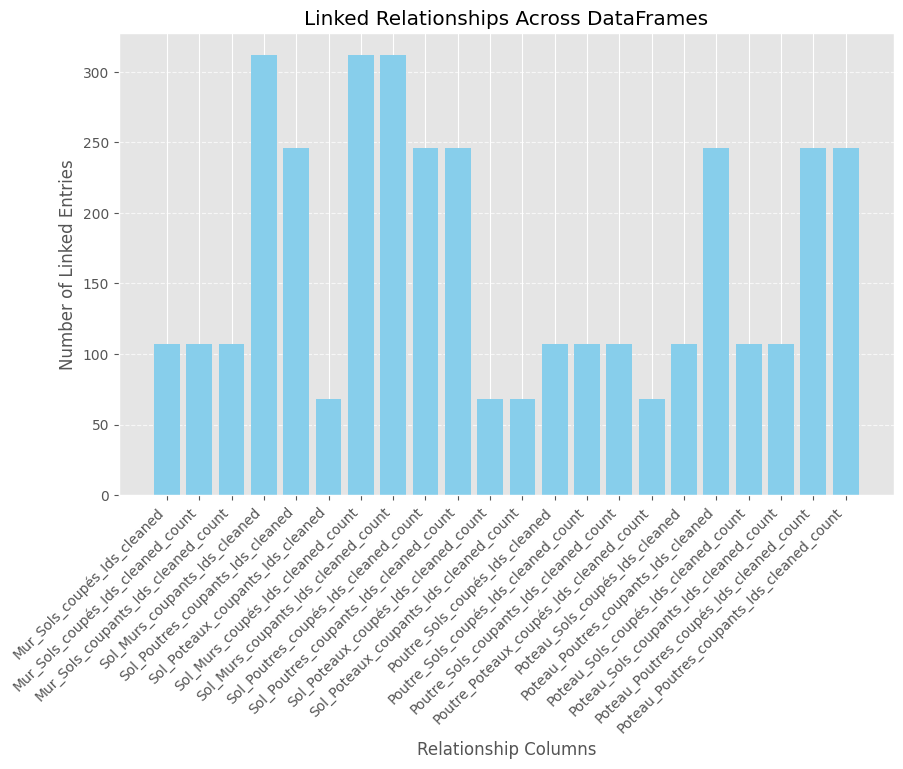

Interactive graph saved to ../../plot/RawData-Cibles/RawData-Cibles_linked_relationships.html


In [8]:
### ======================
### Link ID relationships
### ====================
from excel_link_id_relationships import link_id_relationships, plot_linked_relationships, plotly_network_graph
df_dict = {
    "Murs": murs_df,
    "Sols": sols_df,
    "Poutres": poutres_df,
    "Poteaux": poteaux_df
}
df_dict, linked_columns = link_id_relationships(df_dict)

### ====================================
### Visualize the linked relationships
### ====================================
plot_linked_relationships(df_dict, linked_columns)

### save the graph if not already saved
graph_path = os.path.join(plots_folder, f"{maquette_name}_linked_relationships.png")
if not os.path.exists(graph_path):
    plt.savefig(graph_path, bbox_inches='tight')
    print(f"Graph saved to {graph_path}")


### Generate relationship graph
graph_links = plotly_network_graph(df_dict, linked_columns)
html_path = os.path.join(plots_folder, f"{maquette_name}_linked_relationships.html")
graph_links.write_html(html_path)
print(f"Interactive graph saved to {html_path}")


In [9]:
# import plotly.graph_objects as go
# import networkx as nx

# def plotly_graphs(df_dict, column_mapping):
#     """
#     Creates two interactive network graphs:
#     - One for individual ID-based relationships (one node per connection).
#     - One for quantity-based coupés and coupants relationships.

#     Args:
#         df_dict (dict): Dictionary containing DataFrames.
#         column_mapping (dict): Mapping of sanitized column relationships.

#     Returns:
#         Tuple (fig_id_graph, fig_quantity_graph): Two Plotly figure objects.
#     """
#     G_ids = nx.Graph()  # Graph for ID-based relationships
#     G_quantities = nx.Graph()  # Graph for coupés and coupants relationships

#     # Build quantity-based graph for coupés/coupants relationships
#     for main_df_name, df in df_dict.items():
#         G_quantities.add_node(main_df_name, label=main_df_name, type='dataframe')

#         for column in df.columns:
#             if "_coupés_u" in column or "_coupants_u" in column:
#                 total_count = df[column].sum()
#                 if total_count > 0:  # Only add if there are actual relationships
#                     # Extract the target object type from column name
#                     parts = column.split('_')
#                     target_type = parts[1] if len(parts) > 1 else "Unknown"
#                     relation_type = "coupés" if "_coupés_u" in column else "coupants"

#                     edge_label = f"{main_df_name} {relation_type} {target_type}: {total_count}"
#                     G_quantities.add_edge(main_df_name, f"{target_type}s",
#                                         label=edge_label, weight=total_count)

#     # Build ID-based graph with individual connection nodes
#     for main_df_name, df in df_dict.items():
#         G_ids.add_node(main_df_name, label=main_df_name, type='dataframe')

#         for column in df.columns:
#             if "_coupés_Ids_cleaned" in column or "_coupants_Ids_cleaned" in column:
#                 # Extract target type and relation type
#                 parts = column.split('_')
#                 target_type = parts[1] if len(parts) > 1 else "Unknown"
#                 relation_type = "coupés" if "_coupés_Ids_cleaned" in column else "coupants"

#                 # Process each row to create individual connections
#                 for idx, row in df.iterrows():
#                     ids_value = row[column]
#                     if pd.notna(ids_value) and str(ids_value).strip():
#                         # Split IDs and create individual connection nodes
#                         ids_list = str(ids_value).split(',')
#                         for individual_id in ids_list:
#                             individual_id = individual_id.strip()
#                             if individual_id:
#                                 # Create unique connection node - handle column name mapping
#                                 if main_df_name == 'Poteaux':
#                                     id_column = 'Poteau_Id'
#                                 elif main_df_name == 'Poutres':
#                                     id_column = 'Poutre_Id'
#                                 elif main_df_name == 'Murs':
#                                     id_column = 'Mur_Id'
#                                 elif main_df_name == 'Sols':
#                                     id_column = 'Sol_Id'
#                                 else:
#                                     id_column = f'{main_df_name.rstrip("s")}_Id'
#                                 connection_node = f"{main_df_name}_{row[id_column]}_{relation_type}_{individual_id}"

#                                 G_ids.add_node(connection_node,
#                                              label=f"{relation_type}\n{individual_id}",
#                                              type='connection')

#                                 # Connect main dataframe to connection node
#                                 G_ids.add_edge(main_df_name, connection_node,
#                                              label=f"{main_df_name}→{individual_id}")

#                                 # Connect connection node to target dataframe
#                                 target_df = f"{target_type}s"
#                                 if target_df in df_dict:
#                                     G_ids.add_edge(connection_node, target_df,
#                                                  label=f"{individual_id}→{target_df}")

#     # Position nodes using different layouts
#     pos_ids = nx.spring_layout(G_ids, seed=42, k=3, iterations=50)
#     pos_quantities = nx.spring_layout(G_quantities, seed=42, k=2, iterations=50)

#     def create_graph_trace(G, pos, title_suffix=""):
#         """ Helper function to generate graph traces """
#         edge_x, edge_y, edge_text = [], [], []

#         for edge in G.edges():
#             x0, y0 = pos[edge[0]]
#             x1, y1 = pos[edge[1]]
#             edge_x += [x0, x1, None]
#             edge_y += [y0, y1, None]
#             # Get edge data safely
#             edge_data = G.edges[edge] if isinstance(G.edges[edge], dict) else {}
#             edge_text.append(edge_data.get('label', ''))

#         edge_trace = go.Scatter(x=edge_x, y=edge_y,
#                                line=dict(width=1.5, color='#888'),
#                                mode='lines', hoverinfo='none')

#         node_x, node_y, node_text, node_color, node_size = [], [], [], [], []
#         for node in G.nodes():
#             x, y = pos[node]
#             node_x.append(x)
#             node_y.append(y)
#             # Get node data safely
#             node_data = G.nodes[node] if isinstance(G.nodes[node], dict) else {}
#             node_type = node_data.get('type', 'default')

#             node_type = G.nodes[node]['type']
#             if node_type == 'dataframe':
#                 node_color.append('blue')
#                 node_size.append(25)
#             elif node_type == 'connection':
#                 node_color.append('red')
#                 node_size.append(15)
#             else:
#                 node_color.append('green')
#                 node_size.append(20)

#         node_trace = go.Scatter(
#             x=node_x, y=node_y,
#             mode='markers+text',
#             text=node_text,
#             textposition="top center",
#             hoverinfo='text',
#             marker=dict(showscale=False, color=node_color, size=node_size, line_width=2)
#         )
#         return edge_trace, node_trace

#     # Create ID-based graph
#     edge_trace_ids, node_trace_ids = create_graph_trace(G_ids, pos_ids)
#     fig_id_graph = go.Figure(data=[edge_trace_ids, node_trace_ids],
#                              layout=go.Layout(
#                                  title=dict(text='🔗 Individual ID Relationship Network', font=dict(size=16)),
#                                  showlegend=False,
#                                  hovermode='closest',
#                                  margin=dict(b=20, l=5, r=5, t=40),
#                                  xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
#                                  yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
#                              ))

#     # Create Quantity-based graph
#     edge_trace_quantities, node_trace_quantities = create_graph_trace(G_quantities, pos_quantities)
#     fig_quantity_graph = go.Figure(data=[edge_trace_quantities, node_trace_quantities],
#                                    layout=go.Layout(
#                                        title=dict(text='📊 Quantity Relationship Network (coupés & coupants)', font=dict(size=16)),
#                                        showlegend=False,
#                                        hovermode='closest',
#                                        margin=dict(b=20, l=5, r=5, t=40),
#                                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
#                                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
#                                    ))

#     return fig_id_graph, fig_quantity_graph


# fig_id_graph, fig_quantity_graph = plotly_graphs(sanitized_data, relationships)
# fig_id_graph.show()
# fig_quantity_graph.show()

In [10]:
###
### Show the network graph in a web browser
###
# import webbrowser
# webbrowser.open(os.path.join(plots_folder, "network_graph_quantities.html"))

# Feature Engineering & Target Preparation & Exploratory Data Analysis & Correlation Analysis

In [11]:
import pandas as pd
import re

def drop_specific_target_columns(df_dict):
    """
    Drops columns that match ['011ec_lot', '012ec_ouvrage', '013ec_localisation', '014ec_mode_constructif']
    while preserving prefixed versions (e.g., 'mur_011ec_lot', 'sol_012ec_ouvrage', etc.).

    Args:
        df_dict (dict): Dictionary of DataFrames.

    Returns:
        cleaned_dict (dict): Dictionary with target columns removed where applicable.
    """
    target_columns = ['011ec_lot', '012ec_ouvrage', '013ec_localisation', '014ec_mode_constructif']
    prefixes = ['mur_', 'sol_', 'poutre_', 'poteau_']

    cleaned_dict = {}

    for df_name, df in df_dict.items():
        # Identify columns to drop that do NOT start with allowed prefixes
        cols_to_drop = [col for col in df.columns if any(col == target for target in target_columns) and not any(col.startswith(pref) for pref in prefixes)]

        # Drop selected columns
        cleaned_df = df.drop(columns=cols_to_drop)
        cleaned_dict[df_name] = cleaned_df

        print(f"Dropped {len(cols_to_drop)} columns from {df_name}: {cols_to_drop}")

    return cleaned_dict

def drop_missing_columns(df_dict):
    """Drop columns with 100% missing values."""
    cleaned_dict = {}
    for df_name, df in df_dict.items():
        missing_percent = df.isna().mean()
        cols_to_drop = missing_percent[missing_percent == 1].index.tolist()
        cleaned_df = df.drop(columns=cols_to_drop)
        cleaned_dict[df_name] = cleaned_df
        print(f"Dropped {len(cols_to_drop)} 100% missing columns from {df_name}")
    return cleaned_dict

def drop_id_count_columns(df_dict):
    """Drop columns containing 'ids_cleaned_count' (case insensitive)."""
    cleaned_dict = {}
    for df_name, df in df_dict.items():
        count_cols = [col for col in df.columns if re.search(r'ids_cleaned_count', col, re.IGNORECASE)]
        cleaned_df = df.drop(columns=count_cols)
        cleaned_dict[df_name] = cleaned_df
        print(f"Dropped {len(count_cols)} ID count columns from {df_name}")
    return cleaned_dict

print("\n=== Cleaning Data ===")

# Initialize processed_df_v3 using the existing dataframes
processed_df_v3 = {
    "Murs": murs_df,
    "Sols": sols_df,
    "Poutres": poutres_df,
    "Poteaux": poteaux_df
}

processed_df_v3 = drop_missing_columns(processed_df_v3)
processed_df_v3 = drop_id_count_columns(processed_df_v3)
processed_df_v3 = drop_specific_target_columns(processed_df_v3)


=== Cleaning Data ===
Dropped 29 100% missing columns from Murs
Dropped 117 100% missing columns from Sols
Dropped 172 100% missing columns from Poutres
Dropped 339 100% missing columns from Poteaux
Dropped 2 ID count columns from Murs
Dropped 6 ID count columns from Sols
Dropped 3 ID count columns from Poutres
Dropped 4 ID count columns from Poteaux
Dropped 0 columns from Murs: []
Dropped 0 columns from Sols: []
Dropped 0 columns from Poutres: []
Dropped 0 columns from Poteaux: []


In [12]:
def standardize_columns(df_dict):
    """Convert all column names to lowercase and standardize dataframe names."""
    try:
        standardized_dict = {}
        for df_name, df in df_dict.items():
            df.columns = df.columns.str.lower()
            standardized_dict[df_name.lower()] = df
        return standardized_dict
    except Exception as e:
        print(f"Error in standardize_columns: {str(e)}")
        raise

# Data Standardization
print("\n=== Standardizing Data ===")
processed_df_v3 = standardize_columns(processed_df_v3)

# Display standardized DataFrame names and columns
print("\nStandardized DataFrames:")
for df_name, df in processed_df_v3.items():
    print(f"\n{df_name} DataFrame:")
    print(df.columns.tolist())


=== Standardizing Data ===

Standardized DataFrames:

murs DataFrame:
['mur_id', 'mur_011ec_lot', 'mur_012ec_ouvrage', 'mur_013ec_localisation', 'mur_014ec_mode_constructif', 'mur_hauteur', 'mur_epaisseur', 'mur_ai', 'mur_as', 'mur_sols_en_intersection', 'mur_sols_coupés_u', 'mur_sols_coupants_u', 'mur_sols_coupants_ids_cleaned', 'mur_sol_au-dessus', 'mur_sol_en-dessous', 'mur_fenêtres', 'mur_portes', 'mur_ouvertures', 'mur_murs_imbriqués', 'mur_mur_multicouche', 'mur_profil_modifié', 'mur_extension_inférieure', 'mur_extension_supérieure', 'mur_volume', 'mur_surface', 'mur_partie_inférieure_attachée', 'mur_partie_supérieure_attachée', 'mur_décalage_supérieur', 'mur_décalage_inférieur', 'mur_matériau_structurel']

sols DataFrame:
['sol_id', 'sol_011ec_lot', 'sol_012ec_ouvrage', 'sol_013ec_localisation', 'sol_014ec_mode_constructif', 'sol_murs_en_intersection', 'sol_murs_coupés_u', 'sol_murs_coupés_ids_cleaned', 'sol_murs_coupants_u', 'sol_poutres_en_intersection', 'sol_poutres_coupés_u

In [13]:
def identify_targets(df_dict):
    """Identify target columns safely, avoiding missing column errors, and store results in processed_df_v."""
    try:
        target_patterns = ['011ec_lot', '012ec_ouvrage', '013ec_localisation', '014ec_mode_constructif']

        targets, features = {}, {}
        processed_df_v = {}  # Dictionary to store processed DataFrames

        for df_name, df in df_dict.items():
            df.columns = df.columns.str.lower()  # Standardize column names

            # Find matching target columns that actually exist
            target_cols = [col for col in df.columns if any(re.search(patt, col, re.IGNORECASE) for patt in target_patterns)]
            existing_targets = [col for col in target_cols if col in df.columns]  # Avoid KeyErrors

            feature_cols = [col for col in df.columns if col not in existing_targets]

            targets[df_name] = df[existing_targets]
            features[df_name] = df[feature_cols]

            # Store processed DataFrame in processed_df_v
            processed_df_v[df_name] = df

            print(f"Identified {len(existing_targets)} target columns in {df_name}: {existing_targets}")

        return targets, features, processed_df_v
    except Exception as e:
        print(f"Error in identify_targets: {str(e)}")
        raise

# Identifying Targets
print("\n=== Identifying Targets ===")
targets, features, processed_df_v = identify_targets(processed_df_v3)


=== Identifying Targets ===
Identified 4 target columns in murs: ['mur_011ec_lot', 'mur_012ec_ouvrage', 'mur_013ec_localisation', 'mur_014ec_mode_constructif']
Identified 4 target columns in sols: ['sol_011ec_lot', 'sol_012ec_ouvrage', 'sol_013ec_localisation', 'sol_014ec_mode_constructif']
Identified 4 target columns in poutres: ['poutre_011ec_lot', 'poutre_012ec_ouvrage', 'poutre_013ec_localisation', 'poutre_014ec_mode_constructif']
Identified 4 target columns in poteaux: ['poteau_011ec_lot', 'poteau_012ec_ouvrage', 'poteau_013ec_localisation', 'poteau_014ec_mode_constructif']


In [14]:
for df_name, df in processed_df_v3.items():
    print(f"📊 Numeric Columns in {df_name}: {df.select_dtypes(include=[np.number]).columns.tolist()}")

📊 Numeric Columns in murs: ['mur_id', 'mur_hauteur', 'mur_epaisseur', 'mur_ai', 'mur_as', 'mur_sols_en_intersection', 'mur_sols_coupés_u', 'mur_sols_coupants_u', 'mur_fenêtres', 'mur_portes', 'mur_ouvertures', 'mur_murs_imbriqués', 'mur_extension_inférieure', 'mur_extension_supérieure', 'mur_volume', 'mur_surface', 'mur_partie_inférieure_attachée', 'mur_partie_supérieure_attachée', 'mur_décalage_supérieur', 'mur_décalage_inférieur']
📊 Numeric Columns in sols: ['sol_id', 'sol_murs_en_intersection', 'sol_murs_coupés_u', 'sol_murs_coupants_u', 'sol_poutres_en_intersection', 'sol_poutres_coupés_u', 'sol_poutres_coupants_u', 'sol_poteaux_en_intersection', 'sol_poteaux_coupés_u', 'sol_poteaux_coupants_u', 'sol_volume', 'sol_surface']
📊 Numeric Columns in poutres: ['poutre_id', 'poutre_ai', 'poutre_as', 'poutre_hauteur_totale', 'poutre_hauteur', 'poutre_sols_en_intersection', 'poutre_sols_coupés_u', 'poutre_sols_coupants_u', 'poutre_poteaux_en_intersection', 'poutre_poteaux_coupés_u', 'poutre

In [15]:
for df_name, target_df in targets.items():
    print(f"🔍 Numeric Target Columns in {df_name}: {target_df.select_dtypes(include=[np.number]).columns.tolist()}")

🔍 Numeric Target Columns in murs: []
🔍 Numeric Target Columns in sols: []
🔍 Numeric Target Columns in poutres: []
🔍 Numeric Target Columns in poteaux: []


In [ ]:
def clean_targets_and_fill_ids_cleaned(df_dict, target_patterns):
    """
    Cleans '_ids_cleaned' columns by filling NaN values with 0,
    and drops rows where any target columns match patterns and contain NaN or '_ids_cleaned'.

    Args:
        df_dict (dict): Dictionary of DataFrames.
        target_patterns (list): List of target column patterns to check for removal.

    Returns:
        updated_dict (dict): Dictionary with cleaned DataFrames.
    """
    updated_dict = {}

    for df_name, df in df_dict.items():
        print(f"\n🔍 Processing {df_name}...")

        # Record original shape
        original_shape = df.shape

        # Fill NaN values with 0 in '_ids_cleaned' columns
        ids_cleaned_cols = [col for col in df.columns if "_ids_cleaned" in col]
        df[ids_cleaned_cols] = df[ids_cleaned_cols].fillna(0)

        # Drop rows where any target columns contain NaN or '_ids_cleaned'
        target_cols = [col for col in df.columns if any(pattern in col for pattern in target_patterns)]
        drop_condition = df[target_cols].apply(lambda row: row.astype(str).str.contains("_ids_cleaned|nan", case=False)).any(axis=1)
        df = df[~drop_condition]

        # Record new shape after processing
        new_shape = df.shape
        updated_dict[df_name] = df

        print(f"✅ {df_name}: Shape before = {original_shape}, after = {new_shape}")
        print(f"   🛠 Filled NaN in {len(ids_cleaned_cols)} '_ids_cleaned' columns: {ids_cleaned_cols}")
        print(f"   🗑 Dropped {original_shape[0] - new_shape[0]} rows due to target column cleanup")

    return updated_dict

target_patterns = ['011ec_lot', '012ec_ouvrage', '013ec_localisation', '014ec_mode_constructif']
processed_df_v3 = clean_targets_and_fill_ids_cleaned(processed_df_v3, target_patterns)


🔍 Processing murs...
✅ murs: Shape before = (312, 30), after = (312, 30)
   🛠 Filled NaN in 1 '_ids_cleaned' columns: ['mur_sols_coupants_ids_cleaned']
   🗑 Dropped 0 rows due to target column cleanup

🔍 Processing sols...
✅ sols: Shape before = (107, 20), after = (103, 20)
   🛠 Filled NaN in 3 '_ids_cleaned' columns: ['sol_murs_coupés_ids_cleaned', 'sol_poutres_coupés_ids_cleaned', 'sol_poteaux_coupés_ids_cleaned']
   🗑 Dropped 4 rows due to target column cleanup

🔍 Processing poutres...
✅ poutres: Shape before = (246, 22), after = (242, 22)
   🛠 Filled NaN in 2 '_ids_cleaned' columns: ['poutre_sols_coupants_ids_cleaned', 'poutre_poteaux_coupés_ids_cleaned']
   🗑 Dropped 4 rows due to target column cleanup

🔍 Processing poteaux...
✅ poteaux: Shape before = (68, 25), after = (68, 25)
   🛠 Filled NaN in 3 '_ids_cleaned' columns: ['poteau_sols_coupants_ids_cleaned', 'poteau_poutres_coupés_ids_cleaned', 'poteau_poutres_coupants_ids_cleaned']
   🗑 Dropped 0 rows due to target column clean

In [17]:
import pandas as pd

def split_and_match_ids_cleaned(df_dict, reference_dfs):
    """
    Splits comma-separated IDs in '_ids_cleaned' columns, expands the DataFrame, and finds corresponding matches in reference DataFrames.

    Args:
        df_dict (dict): Dictionary of DataFrames where '_ids_cleaned' needs processing.
        reference_dfs (dict): Dictionary of reference DataFrames to match IDs.

    Returns:
        updated_dict (dict): Dictionary with expanded rows and matched IDs.
    """
    updated_dict = {}

    for df_name, df in df_dict.items():
        print(f"\n🔍 Processing {df_name}...")

        # Identify columns containing '_ids_cleaned'
        ids_cleaned_cols = [col for col in df.columns if "_ids_cleaned" in col]

        if not ids_cleaned_cols:
            print(f"⚠️ No '_ids_cleaned' columns found in {df_name}, skipping...")
            continue

        for col in ids_cleaned_cols:
            # Split comma-separated IDs into lists
            df[col] = df[col].astype(str).str.split(',')

            # Expand rows to separate each ID into individual rows
            df_expanded = df.explode(col).reset_index(drop=True)

            # Ensure IDs are consistent in type (convert both sides to string)
            df_expanded[col] = df_expanded[col].astype(str)  # Convert to string

            # Match corresponding IDs in reference DataFrames
            for ref_name, ref_df in reference_dfs.items():
                if col in ref_df.columns:
                    print(f"🔗 Matching {col} values with {ref_name}...")
                    ref_df[col] = ref_df[col].astype(str)  # Convert reference column to string
                    df_expanded = df_expanded.merge(ref_df[[col]], on=col, how='left')

            updated_dict[df_name] = df_expanded

            print(f"✅ Expanded and matched IDs in {df_name}, new shape: {df_expanded.shape}")

    return updated_dict

# Ensure reference DataFrames are correctly defined
reference_dfs = {
    "murs": processed_df_v3["murs"],
    "sols": processed_df_v3["sols"],
    "poutres": processed_df_v3["poutres"],
    "poteaux": processed_df_v3["poteaux"]
}




# Run the function
processed_df_v3 = split_and_match_ids_cleaned(processed_df_v3, reference_dfs)


🔍 Processing murs...
🔗 Matching mur_sols_coupants_ids_cleaned values with murs...
✅ Expanded and matched IDs in murs, new shape: (386, 30)

🔍 Processing sols...
🔗 Matching sol_murs_coupés_ids_cleaned values with sols...
✅ Expanded and matched IDs in sols, new shape: (234, 20)
🔗 Matching sol_poutres_coupés_ids_cleaned values with sols...
✅ Expanded and matched IDs in sols, new shape: (198, 20)
🔗 Matching sol_poteaux_coupés_ids_cleaned values with sols...
✅ Expanded and matched IDs in sols, new shape: (122, 20)

🔍 Processing poutres...
🔗 Matching poutre_sols_coupants_ids_cleaned values with poutres...
✅ Expanded and matched IDs in poutres, new shape: (285, 22)
🔗 Matching poutre_poteaux_coupés_ids_cleaned values with poutres...
✅ Expanded and matched IDs in poutres, new shape: (246, 22)

🔍 Processing poteaux...
🔗 Matching poteau_sols_coupants_ids_cleaned values with poteaux...
✅ Expanded and matched IDs in poteaux, new shape: (77, 25)
🔗 Matching poteau_poutres_coupés_ids_cleaned values w

In [18]:
for df_name, df in processed_df_v3.items():
    print(f"🛑 NaN percentage in {df_name}: \n{df.isna().mean() * 100}")

🛑 NaN percentage in murs: 
mur_id                            0.0
mur_011ec_lot                     0.0
mur_012ec_ouvrage                 0.0
mur_013ec_localisation            0.0
mur_014ec_mode_constructif        0.0
mur_hauteur                       0.0
mur_epaisseur                     0.0
mur_ai                            0.0
mur_as                            0.0
mur_sols_en_intersection          0.0
mur_sols_coupés_u                 0.0
mur_sols_coupants_u               0.0
mur_sols_coupants_ids_cleaned     0.0
mur_sol_au-dessus                 0.0
mur_sol_en-dessous                0.0
mur_fenêtres                      0.0
mur_portes                        0.0
mur_ouvertures                    0.0
mur_murs_imbriqués                0.0
mur_mur_multicouche               0.0
mur_profil_modifié                0.0
mur_extension_inférieure          0.0
mur_extension_supérieure          0.0
mur_volume                        0.0
mur_surface                       0.0
mur_partie_inférieure_a

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

def check_and_encode_all_dataframes(df_dict):
    """
    Displays data types before encoding and converts all non-numeric columns to numeric using Label Encoding.

    Args:
        df_dict (dict): Dictionary containing all DataFrames.

    Returns:
        encoded_dict (dict): Dictionary of encoded DataFrames.
        label_encoders (dict): Dictionary of LabelEncoders used for transformation.
    """
    encoded_dict = {}
    label_encoders = {}

    for df_name, df in df_dict.items():
        print(f"\n🔍 Data Types Before Encoding in {df_name}:")
        print(df.dtypes)

        # Encode non-numeric columns
        encoders = {}
        for col in df.select_dtypes(exclude=[np.number]).columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))  # Convert text to numeric codes
            encoders[col] = le  # Store encoder for future use

        encoded_dict[df_name] = df
        label_encoders[df_name] = encoders

        print(f"\n✅ Data Types After Encoding in {df_name}:")
        print(df.dtypes)

    return encoded_dict, label_encoders

encoded_targets, label_encoders = check_and_encode_all_dataframes(processed_df_v3)


🔍 Data Types Before Encoding in murs:
mur_id                              int64
mur_011ec_lot                      object
mur_012ec_ouvrage                  object
mur_013ec_localisation             object
mur_014ec_mode_constructif         object
mur_hauteur                       float64
mur_epaisseur                     float64
mur_ai                            float64
mur_as                            float64
mur_sols_en_intersection            int64
mur_sols_coupés_u                   int64
mur_sols_coupants_u                 int64
mur_sols_coupants_ids_cleaned      object
mur_sol_au-dessus                    bool
mur_sol_en-dessous                   bool
mur_fenêtres                        int64
mur_portes                          int64
mur_ouvertures                      int64
mur_murs_imbriqués                  int64
mur_mur_multicouche                  bool
mur_profil_modifié                   bool
mur_extension_inférieure            int64
mur_extension_supérieure            i

In [20]:
for df_name, df in encoded_targets.items():
    print(f"🔍 Numeric Columns in {df_name}: {df.select_dtypes(include=[np.number]).columns.tolist()}")

🔍 Numeric Columns in murs: ['mur_id', 'mur_011ec_lot', 'mur_012ec_ouvrage', 'mur_013ec_localisation', 'mur_014ec_mode_constructif', 'mur_hauteur', 'mur_epaisseur', 'mur_ai', 'mur_as', 'mur_sols_en_intersection', 'mur_sols_coupés_u', 'mur_sols_coupants_u', 'mur_sols_coupants_ids_cleaned', 'mur_sol_au-dessus', 'mur_sol_en-dessous', 'mur_fenêtres', 'mur_portes', 'mur_ouvertures', 'mur_murs_imbriqués', 'mur_mur_multicouche', 'mur_profil_modifié', 'mur_extension_inférieure', 'mur_extension_supérieure', 'mur_volume', 'mur_surface', 'mur_partie_inférieure_attachée', 'mur_partie_supérieure_attachée', 'mur_décalage_supérieur', 'mur_décalage_inférieur', 'mur_matériau_structurel']
🔍 Numeric Columns in sols: ['sol_id', 'sol_011ec_lot', 'sol_012ec_ouvrage', 'sol_013ec_localisation', 'sol_014ec_mode_constructif', 'sol_murs_en_intersection', 'sol_murs_coupés_u', 'sol_murs_coupés_ids_cleaned', 'sol_murs_coupants_u', 'sol_poutres_en_intersection', 'sol_poutres_coupés_u', 'sol_poutres_coupés_ids_cleaned

In [21]:
# Define the actual target columns per DataFrame
target_columns = {
    "murs": ['mur_011ec_lot', 'mur_012ec_ouvrage', 'mur_013ec_localisation', 'mur_014ec_mode_constructif'],
    "sols": ['sol_011ec_lot', 'sol_012ec_ouvrage', 'sol_013ec_localisation', 'sol_014ec_mode_constructif'],
    "poutres": ['poutre_011ec_lot', 'poutre_012ec_ouvrage', 'poutre_013ec_localisation', 'poutre_014ec_mode_constructif'],
    "poteaux": ['poteau_011ec_lot', 'poteau_012ec_ouvrage', 'poteau_013ec_localisation', 'poteau_014ec_mode_constructif']
}

# Filter encoded targets to only keep the required columns
filtered_encoded_targets = {df_name: encoded_targets[df_name][target_columns[df_name]] for df_name in encoded_targets.keys()}

for df_name in filtered_encoded_targets.keys():
    print(f"📏 Adjusted Target shape in {df_name}: {filtered_encoded_targets[df_name].shape}")

📏 Adjusted Target shape in murs: (386, 4)
📏 Adjusted Target shape in sols: (122, 4)
📏 Adjusted Target shape in poutres: (246, 4)
📏 Adjusted Target shape in poteaux: (68, 4)


In [22]:
for df_name in processed_df_v3.keys():
    print(f"📏 Feature shape in {df_name}: {processed_df_v3[df_name].shape}")
    print(f"📏 Target shape in {df_name}: {filtered_encoded_targets[df_name].shape}")

📏 Feature shape in murs: (386, 30)
📏 Target shape in murs: (386, 4)
📏 Feature shape in sols: (122, 20)
📏 Target shape in sols: (122, 4)
📏 Feature shape in poutres: (246, 22)
📏 Target shape in poutres: (246, 4)
📏 Feature shape in poteaux: (68, 25)
📏 Target shape in poteaux: (68, 4)


In [23]:
for df_name, df in encoded_targets.items():
    print(f"📊 Unique values per column in {df_name}:")
    print(df.nunique())

📊 Unique values per column in murs:
mur_id                            312
mur_011ec_lot                       1
mur_012ec_ouvrage                   7
mur_013ec_localisation              6
mur_014ec_mode_constructif          5
mur_hauteur                       106
mur_epaisseur                      14
mur_ai                             47
mur_as                             75
mur_sols_en_intersection            5
mur_sols_coupés_u                   1
mur_sols_coupants_u                 5
mur_sols_coupants_ids_cleaned      62
mur_sol_au-dessus                   2
mur_sol_en-dessous                  2
mur_fenêtres                        5
mur_portes                          5
mur_ouvertures                      1
mur_murs_imbriqués                  1
mur_mur_multicouche                 1
mur_profil_modifié                  2
mur_extension_inférieure            1
mur_extension_supérieure            1
mur_volume                        311
mur_surface                       311
mur_partie_inf

In [78]:
for df_name, df in filtered_encoded_targets.items():
    # Convert object columns to numeric, forcing errors to NaN for safety
    df = df.apply(pd.to_numeric, errors='coerce')
    filtered_encoded_targets[df_name] = df  # Store converted DataFrame

In [28]:
for df_name, df in filtered_encoded_targets.items():
    print(f"🔎 Checking final data types in {df_name}:")
    print(df.dtypes)

🔎 Checking final data types in murs:
mur_011ec_lot                 int64
mur_012ec_ouvrage             int64
mur_013ec_localisation        int64
mur_014ec_mode_constructif    int64
dtype: object
🔎 Checking final data types in sols:
sol_011ec_lot                 int64
sol_012ec_ouvrage             int64
sol_013ec_localisation        int64
sol_014ec_mode_constructif    int64
dtype: object
🔎 Checking final data types in poutres:
poutre_011ec_lot                 int64
poutre_012ec_ouvrage             int64
poutre_013ec_localisation        int64
poutre_014ec_mode_constructif    int64
dtype: object
🔎 Checking final data types in poteaux:
poteau_011ec_lot                 int64
poteau_012ec_ouvrage             int64
poteau_013ec_localisation        int64
poteau_014ec_mode_constructif    int64
dtype: object


In [29]:
def calculate_feature_target_correlation(df_dict, target_columns):
    """
    Calculate correlation between features and target columns for each DataFrame.

    Args:
        df_dict (dict): Dictionary of DataFrames containing features.
        target_columns (dict): Dictionary specifying target columns for each DataFrame.

    Returns:
        correlation_results (dict): Dictionary containing correlation matrices for each DataFrame.
    """
    correlation_results = {}

    for df_name, df in df_dict.items():
        print(f"\n🔍 Calculating feature-target correlation for {df_name}...")

        if df_name not in target_columns:
            print(f"⚠️ No target columns specified for {df_name}, skipping...")
            continue

        # Ensure target columns exist in the DataFrame
        existing_targets = [col for col in target_columns[df_name] if col in df.columns]

        if not existing_targets:
            print(f"⚠️ No valid target columns found in {df_name}, skipping...")
            continue

        # Calculate correlation matrix between features and target columns
        correlation_matrix = df.corr().loc[:, existing_targets]

        correlation_results[df_name] = correlation_matrix
        print(f"✅ Correlation matrix for {df_name}:")
        print(correlation_matrix)

    return correlation_results


# Calculate correlations
feature_target_correlations = calculate_feature_target_correlation(processed_df_v3, target_columns)



🔍 Calculating feature-target correlation for murs...
✅ Correlation matrix for murs:
                                mur_011ec_lot  mur_012ec_ouvrage  \
mur_id                                    NaN           0.015984   
mur_011ec_lot                             NaN                NaN   
mur_012ec_ouvrage                         NaN           1.000000   
mur_013ec_localisation                    NaN          -0.222816   
mur_014ec_mode_constructif                NaN          -0.031984   
mur_hauteur                               NaN          -0.324023   
mur_epaisseur                             NaN           0.395110   
mur_ai                                    NaN           0.045848   
mur_as                                    NaN          -0.120303   
mur_sols_en_intersection                  NaN           0.090949   
mur_sols_coupés_u                         NaN                NaN   
mur_sols_coupants_u                       NaN           0.047512   
mur_sols_coupants_ids_cleaned  

In [34]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

def calculate_feature_importance(df_dict, target_columns):
    """
    Calculate feature importance for each DataFrame using Random Forest.

    Args:
        df_dict (dict): Dictionary of DataFrames containing features.
        target_columns (dict): Dictionary specifying target columns for each DataFrame.

    Returns:
        dict: Feature importance scores for each DataFrame.
    """
    feature_importance_results = {}

    for df_name, df in df_dict.items():
        targets = target_columns.get(df_name, [])
        valid_targets = [col for col in targets if col in df.columns]

        if not valid_targets:
            print(f"⚠️ Skipping {df_name}: No valid target columns.")
            continue

        X = df.drop(columns=valid_targets).fillna(0)
        importance_scores = {
            target: pd.Series(
                RandomForestRegressor(n_estimators=100, random_state=42)
                .fit(X, df[target].fillna(0))
                .feature_importances_,
                index=X.columns
            ).sort_values(ascending=False)
            for target in valid_targets
        }
        feature_importance_results[df_name] = importance_scores

    return feature_importance_results

def calculate_target_correlation(df_dict, target_columns):
    """
    Calculate correlation matrices for target columns within each DataFrame and across DataFrames.

    Args:
        df_dict (dict): Dictionary of DataFrames containing features and targets.
        target_columns (dict): Dictionary specifying target columns for each DataFrame.

    Returns:
        tuple: Target correlation matrices and cross-DataFrame correlation matrix.
    """
    target_correlation_results = {
        df_name: df[target_columns[df_name]].corr()
        for df_name, df in df_dict.items()
        if df_name in target_columns and all(col in df.columns for col in target_columns[df_name])
    }

    cross_df_correlation_matrix = pd.DataFrame({
        (src_name, tgt_name): src_df.drop(columns=target_columns[src_name], errors='ignore')
        .corrwith(tgt_df[target_columns[tgt_name]].mean(axis=1))
        for src_name, src_df in df_dict.items()
        for tgt_name, tgt_df in df_dict.items()
        if src_name in target_columns and tgt_name in target_columns
    }).T.rename(columns={0: "Correlation"})

    return target_correlation_results, cross_df_correlation_matrix

# Example usage
target_correlation_results, cross_df_correlation_matrix = calculate_target_correlation(processed_df_v3, target_columns)

# Display results
for df_name, corr_matrix in target_correlation_results.items():
    print(f"\n📊 Target Correlation Matrix for {df_name}:\n{corr_matrix}")

print("\n📊 Cross-DataFrame Correlation Matrix:\n", cross_df_correlation_matrix)



📊 Target Correlation Matrix for murs:
                            mur_011ec_lot  mur_012ec_ouvrage  \
mur_011ec_lot                         NaN                NaN   
mur_012ec_ouvrage                     NaN           1.000000   
mur_013ec_localisation                NaN          -0.222816   
mur_014ec_mode_constructif            NaN          -0.031984   

                            mur_013ec_localisation  mur_014ec_mode_constructif  
mur_011ec_lot                                  NaN                         NaN  
mur_012ec_ouvrage                        -0.222816                   -0.031984  
mur_013ec_localisation                    1.000000                    0.284896  
mur_014ec_mode_constructif                0.284896                    1.000000  

📊 Target Correlation Matrix for sols:
                            sol_011ec_lot  sol_012ec_ouvrage  \
sol_011ec_lot                         NaN                NaN   
sol_012ec_ouvrage                     NaN           1.000000   
sol_


🔍 Calculating feature-target correlation for murs...


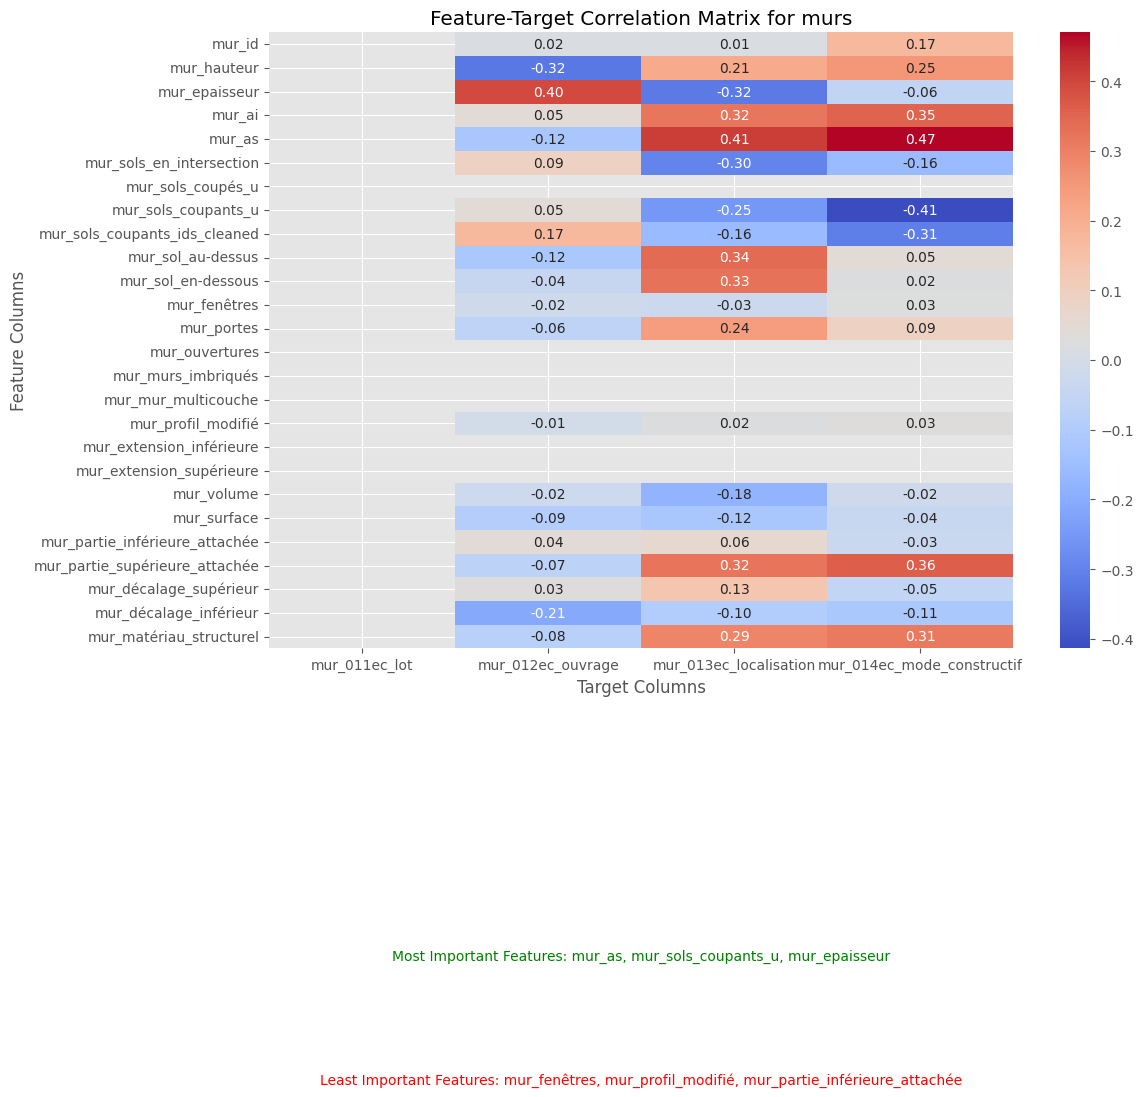


🔍 Calculating feature-target correlation for sols...


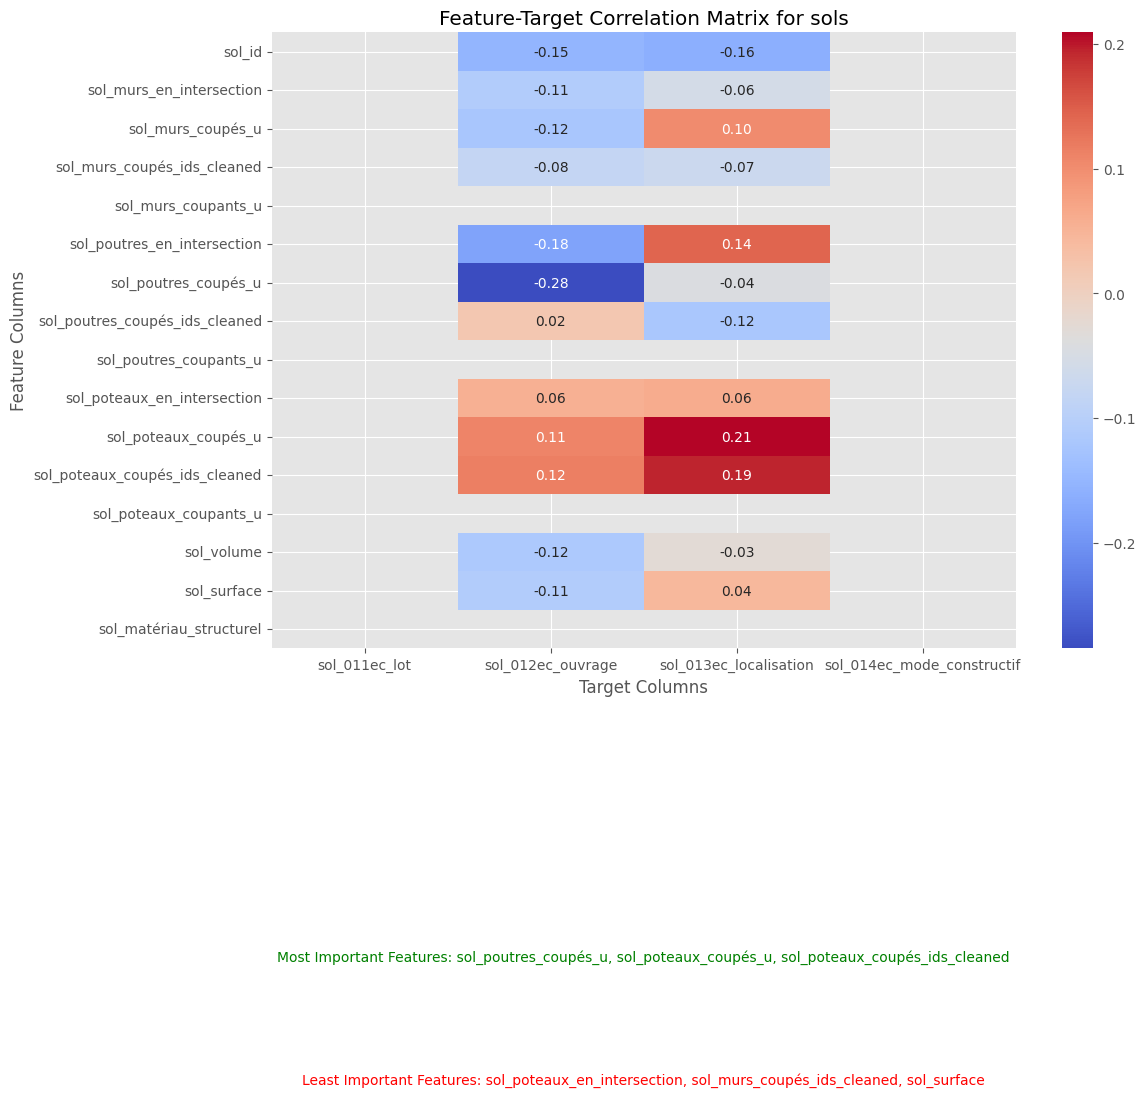


🔍 Calculating feature-target correlation for poutres...


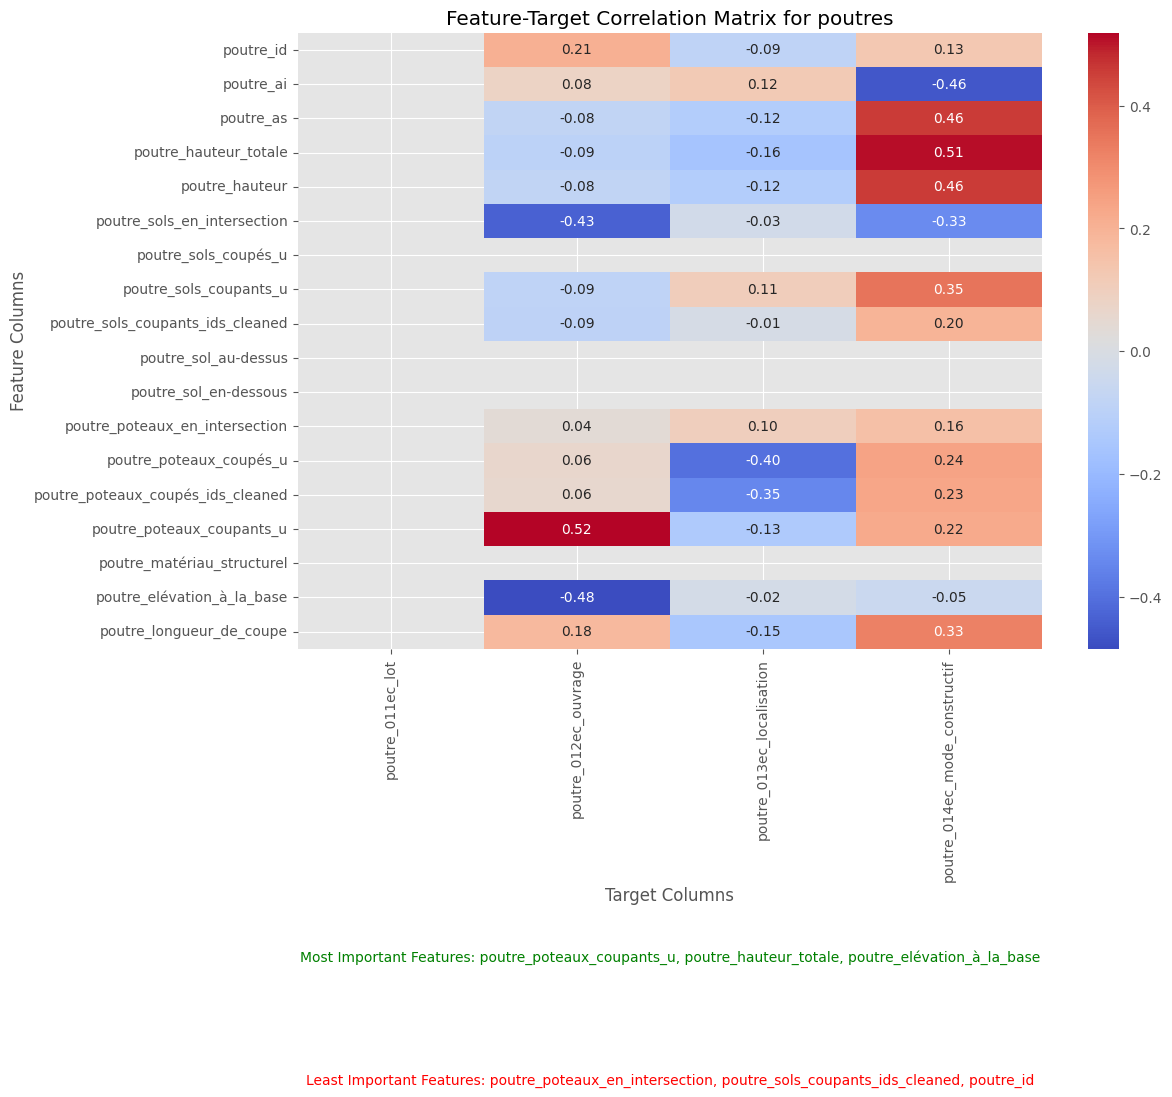


🔍 Calculating feature-target correlation for poteaux...


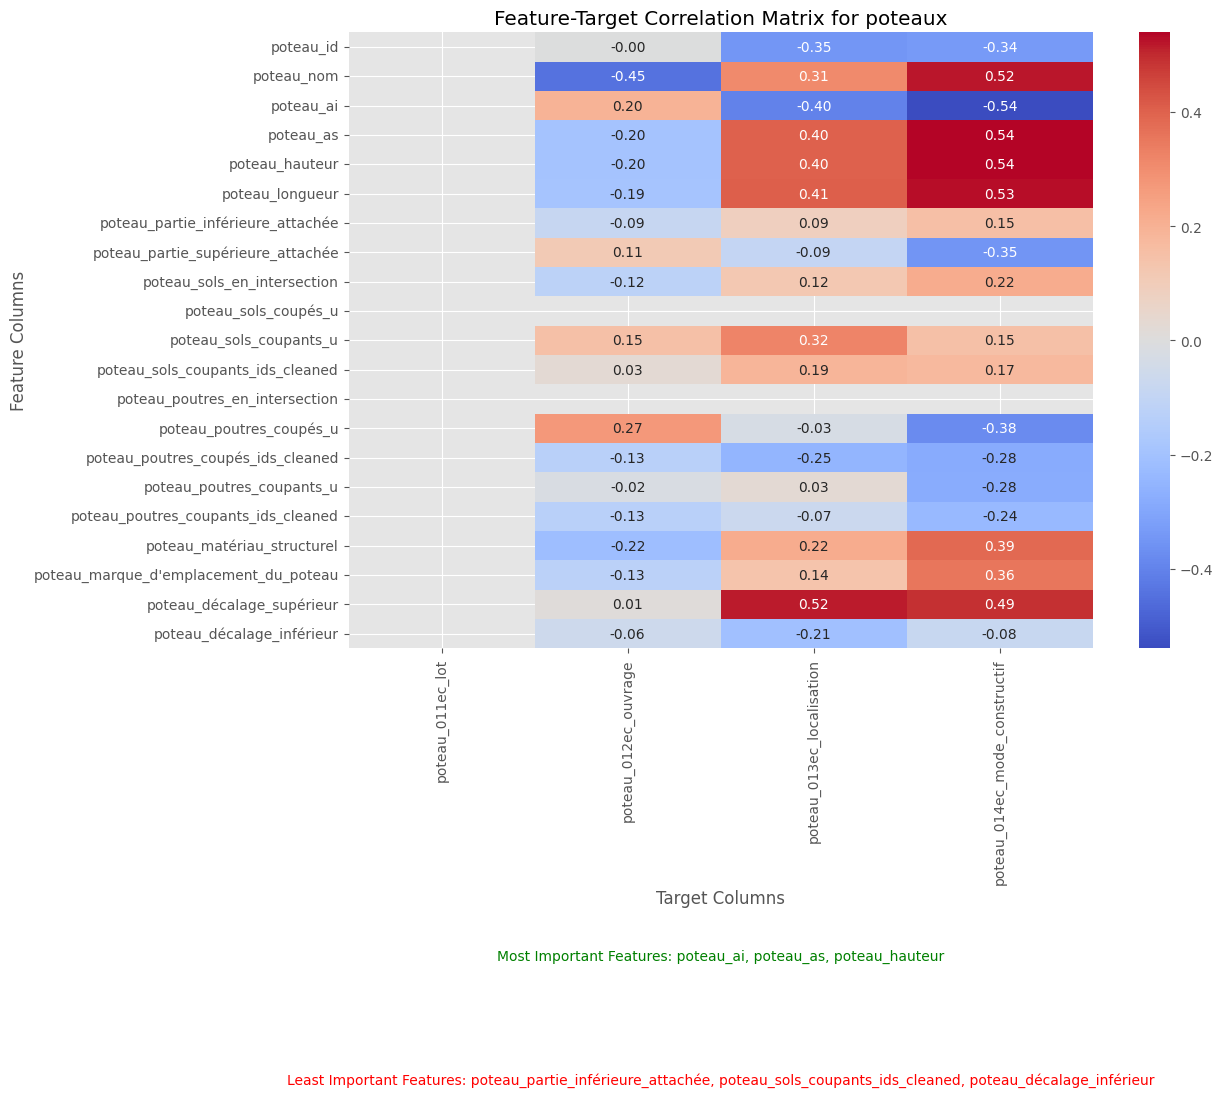

In [ ]:
def plot_feature_target_correlation(df_dict, target_columns):
    """
    Calculate and plot correlation matrices for the importance of each DataFrame's features on its targets.

    Args:
        df_dict (dict): Dictionary of DataFrames containing features and targets.
        target_columns (dict): Dictionary specifying target columns for each DataFrame.
    """
    for df_name, df in df_dict.items():
        print(f"\n🔍 Calculating feature-target correlation for {df_name}...")

        if df_name not in target_columns:
            print(f"⚠️ No target columns specified for {df_name}, skipping...")
            continue

        # Ensure target columns exist in the DataFrame
        existing_targets = [col for col in target_columns[df_name] if col in df.columns]

        if not existing_targets:
            print(f"⚠️ No valid target columns found in {df_name}, skipping...")
            continue

        # Calculate correlation matrix between features and target columns
        feature_cols = [col for col in df.columns if col not in existing_targets]
        correlation_matrix = df[feature_cols + existing_targets].corr().loc[feature_cols, existing_targets]

        # Identify most important and least important features
        most_important_features = correlation_matrix.abs().max(axis=1).sort_values(ascending=False).head(3).index.tolist()
        least_important_features = correlation_matrix.abs().max(axis=1).sort_values(ascending=True).head(3).index.tolist()

        # Plot correlation matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
        plt.title(f"Feature-Target Correlation Matrix for {df_name}")
        plt.xlabel("Target Columns")
        plt.ylabel("Feature Columns")

        # Annotate the plot with the most and least important features
        plt.text(0.5, -0.5, f"Most Important Features: {', '.join(most_important_features)}",
                 fontsize=10, color="green", ha="center", va="center", transform=plt.gca().transAxes)
        plt.text(0.5, -0.7, f"Least Important Features: {', '.join(least_important_features)}",
                 fontsize=10, color="red", ha="center", va="center", transform=plt.gca().transAxes)

        plt.show()


# Plot feature-target correlation matrices
plot_feature_target_correlation(processed_df_v3, target_columns)


In [42]:
### train a Random Forest model for each DataFrame
def train_random_forest_models(df_dict, target_columns):
    """
    Train a Random Forest model for each DataFrame using its features to predict the specified target columns.

    Args:
        df_dict (dict): Dictionary of DataFrames containing features and targets.
        target_columns (dict): Dictionary specifying target columns for each DataFrame.

    Returns:
        dict: Dictionary of trained Random Forest models for each DataFrame.
    """
    models = {}

    for df_name, df in df_dict.items():
        targets = target_columns.get(df_name, [])
        valid_targets = [col for col in targets if col in df.columns]

        if not valid_targets:
            print(f"⚠️ Skipping {df_name}: No valid target columns.")
            continue

        X = df.drop(columns=valid_targets).fillna(0)
        y = df[valid_targets].fillna(0)

        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X, y)

        models[df_name] = model
        print(f"✅ Trained Random Forest model for {df_name} with targets: {valid_targets}")

    return models

##  Model Training and Evaluation


In [82]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt

# Define models capable of multi-target learning
base_models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42),
}

# Convert base models into multi-output classifiers
models = {name: MultiOutputClassifier(model) for name, model in base_models.items()}

# Prepare feature and target data
# Ensure X and y have consistent rows by concatenating DataFrames from the dictionaries
X = pd.concat(encoded_targets.values(), axis=0).reset_index(drop=True)
y = pd.concat(filtered_encoded_targets.values(), axis=0).reset_index(drop=True)

# Split data for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate models
results = {}

for model_name, model in models.items():
    print(f"\n🔄 Training {model_name} on full multi-target dataset...")
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = (y_pred == y_test).mean().mean(axis=0)  # Compute accuracy across multiple targets
        results[model_name] = accuracy
        print(f"{model_name} Accuracy: {accuracy:.4f}")
    except Exception as e:
        print(f"⚠️ Error with {model_name}: {e}")
        results[model_name] = None

# Convert results to DataFrame and sort models by accuracy
df_results = pd.DataFrame.from_dict(results, orient='index', columns=['accuracy']).sort_values(by='accuracy', ascending=False)

# Display sorted rankings
print("\n📊 Model Rankings (Best to Worst):")
display(df_results)

# Plot accuracy
df_results['accuracy'].plot(kind='bar', title='Model Accuracy Rankings for Multi-Target Classification')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

TypeError: 'numpy.ndarray' object is not callable

## Model Interpretation and Deployment

In [ ]:
# Function to interpret best model for each target
def interpret_best_model(target, results, X_processed, y_target):
    """
    Interpret the best model for a target using SHAP

    Args:
        target: Target variable name
        results: Dictionary of model results
        X_processed: Processed features
        y_target: Target values
    """
    if not results:
        return

    # Find best model by accuracy
    df_results = pd.DataFrame(results).T
    best_model_name = df_results['accuracy'].idxmax()
    best_model_accuracy = df_results.loc[best_model_name, 'accuracy']

    print(f"\nInterpreting best model for {target}: {best_model_name} (Accuracy: {best_model_accuracy:.4f})")

    # Load the best model
    if 'NeuralNetwork' in best_model_name:
        model_path = f"dlmodels/{target}_{best_model_name}.h5"
        best_model = tf.keras.models.load_model(model_path)

        # For neural networks, we'll use a different explainer
        # Sample data for faster computation
        X_sample = X_processed[:100] if X_processed.shape[0] > 100 else X_processed

        # Create a SHAP explainer
        explainer = shap.DeepExplainer(best_model, X_sample)
        shap_values = explainer.shap_values(X_sample)

        # Plot summary
        plt.figure()
        shap.summary_plot(shap_values, X_sample, feature_names=all_feature_names)
        plt.title(f'SHAP Summary for {target} ({best_model_name})')
        plt.show()

    else:
        if 'boost' in best_model_name.lower() or 'forest' in best_model_name.lower():
            model_path = f"mlmodels/{target}_{best_model_name}.pkl"
        else:
            model_path = f"simplemodels/{target}_{best_model_name}.pkl"

        import joblib
        best_model = joblib.load(model_path)

        # Create SHAP explainer
        X_sample = X_processed[:100] if X_processed.shape[0] > 100 else X_processed

        if hasattr(best_model, 'predict_proba'):
            explainer = shap.TreeExplainer(best_model)
            shap_values = explainer.shap_values(X_sample)

            # Plot summary
            plt.figure()
            shap.summary_plot(shap_values, X_sample, feature_names=all_feature_names)
            plt.title(f'SHAP Summary for {target} ({best_model_name})')
            plt.show()
        else:
            print(f"Cannot create SHAP explainer for {best_model_name}")

# Interpret best models for each target
for target, results in all_results.items():
    y_target = mur_df[target]
    interpret_best_model(target, results, X_processed, y_target)

# Final recommendations
print("\nFinal Recommendations:")
print("1. The best performing models have been saved in their respective folders (simplemodels/, mlmodels/, dlmodels/)")
print("2. SHAP analysis has been provided for model interpretability")
print("3. Consider feature engineering based on the correlation and SHAP analysis")
print("4. For deployment, use the best model for each target variable")
print("5. Monitor model performance over time as new data becomes available")

## Part 7: Learning Curves and Model Analysis

In [ ]:
# Function to plot learning curves
def plot_learning_curve(model, X, y, model_name, target_name):
    """
    Plot learning curves for a model

    Args:
        model: The model to evaluate
        X: Features
        y: Target
        model_name: Name of the model
        target_name: Name of the target variable
    """
    from sklearn.model_selection import learning_curve

    # If y is categorical, encode it
    if y.dtype == 'object':
        le = LabelEncoder()
        y = le.fit_transform(y)

    # Create CV training and test scores for various training set sizes
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 5))

    # Calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
    plt.plot(train_sizes, test_mean, 'o-', color='green', label='Cross-validation score')

    # Draw bands
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')

    # Create plot
    plt.title(f'Learning Curve for {model_name} ({target_name})')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy Score')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Plot learning curves for best models
for target, results in all_results.items():
    if results:
        # Find best model by accuracy
        df_results = pd.DataFrame(results).T
        best_model_name = df_results['accuracy'].idxmax()

        # Load the best model
        if 'NeuralNetwork' in best_model_name:
            model_path = f"dlmodels/{target}_{best_model_name}.h5"
            best_model = tf.keras.models.load_model(model_path)
        elif 'boost' in best_model_name.lower() or 'forest' in best_model_name.lower():
            model_path = f"mlmodels/{target}_{best_model_name}.pkl"
            import joblib
            best_model = joblib.load(model_path)
        else:
            model_path = f"simplemodels/{target}_{best_model_name}.pkl"
            import joblib
            best_model = joblib.load(model_path)

        # Get target data
        y_target = mur_df[target]

        # Plot learning curve
        plot_learning_curve(best_model, X_processed, y_target, best_model_name, target)

Explanation and Next Steps
This comprehensive solution provides:

Data Loading and Preprocessing: Handles the complex relationships between different BIM elements (Murs, Sols, Poutres, Poteaux) and processes the French text data with special characters.

Feature Engineering: Creates relationship features between different BIM elements based on their intersections and cuts.

Exploratory Data Analysis: Includes correlation analysis and target distribution visualization.

Model Training: Evaluates multiple machine learning models (Logistic Regression, Random Forest, SVM, XGBoost, LightGBM) and a neural network for each target variable.

Model Interpretation: Uses SHAP values to explain model predictions and identify important features.

Model Saving: Saves the best models in appropriate folders based on their complexity (simplemodels/, mlmodels/, dlmodels/).

Learning Curves: Visualizes model performance with increasing training data size.

Next Steps:

Deploy the best models for each target variable in your BIM system.

Set up monitoring to track model performance over time.

Consider implementing an ensemble approach if prediction accuracy needs improvement.

Explore more sophisticated deep learning architectures if you have sufficient data.

Regularly update the models with new project data to maintain accuracy.

